#### Cleaning data and filtering the covid period

In [61]:
import pandas as pd
import numpy as np
import rolling_hrp as rol
import HRP
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("data/ibrx_mensal.xlsx", na_values="-")

# transforming the 'Data' column to a date format
df['Data'] = df['Data'].str.replace('Jan', '01').str.replace('Fev', '02').str.replace('Mar', '03').str.replace('Abr', '04').str.replace('Mai', '05').str.replace('Jun', '06').str.replace('Jul', '07').str.replace('Ago', '08').str.replace('Set', '09').str.replace('Out', '10').str.replace('Nov', '11').str.replace('Dez', '12')
    
def filter_covid(df):
    
    df['Data'] = pd.to_datetime(df['Data'], format='%m-%Y')
    df_covid = df[(df['Data'] >= '2000-01-01') & (df['Data'] <= '2022-06-01')].dropna(axis=1) # dataframe with covid period include
    df_w_covid = df[(df['Data'] >= '2000-01-01') & (df['Data'] <= '2020-02-01')].dropna(axis=1) # dataframe with covid period excluded

    return [df_covid, df_w_covid]


data = filter_covid(df)

In [62]:
def generate_stats(dataframes, suffixes, output_file):
    stats = pd.DataFrame()  # Create an empty dataframe to store the results

    for i, df in enumerate(dataframes):
        # Select only numeric columns
        numeric_columns = df.select_dtypes(include=np.number)
        
        temp_stats = numeric_columns.describe(percentiles=[0.25, 0.5, 0.75])
        temp_stats.loc['std'] = numeric_columns.std()  # Add standard deviation
        temp_stats.loc['skewness'] = numeric_columns.skew()  # Add skewness
        temp_stats.loc['kurtosis'] = numeric_columns.kurtosis()  # Add kurtosis
        
        col_suffix = "" + suffixes[i]  # Add suffix based on the provided list
        temp_stats.columns = [col_suffix + col for col in temp_stats.columns]  # Add suffix to column names
        
        stats = pd.concat([stats, temp_stats], axis=1)  # Concatenate the results for each dataframe horizontally with the previous results

    stats = stats[stats.index.isin(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis'])].T
    stats.to_csv(output_file)
    return stats

returns_stats = generate_stats(data, ['c', ""], 'data/returns_stats.csv')
returns_stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
cALPA4,270.0,2.501244,11.064304,-38.943894,-4.476264,1.960298,8.541899,44.652981,0.051084,1.202992
cABEV3,270.0,1.766507,7.828494,-39.285136,-2.696130,1.911069,6.017561,30.846838,-0.269638,3.362001
cBBDC3,270.0,1.685431,9.667875,-31.030564,-4.788686,1.119226,7.245883,35.732992,0.398518,0.651288
cBBDC4,270.0,1.692227,9.832023,-31.926808,-4.510553,0.907931,8.054829,30.424833,0.189606,0.452099
cBBAS3,270.0,2.140531,11.978648,-40.182422,-4.609942,1.090468,9.405603,47.543975,0.168598,1.611265
cBRKM5,270.0,1.789163,13.424214,-35.961324,-7.167631,0.168634,10.305695,57.672451,0.575106,1.087512
cCMIG4,270.0,1.633314,10.626790,-36.174785,-4.779176,1.779988,7.800991,54.050279,0.367049,2.605696
cCPLE6,270.0,1.406455,9.957783,-33.734939,-4.802310,1.714520,7.540635,28.677014,0.011803,0.262513
cELET3,270.0,1.679600,14.480477,-32.959640,-7.226539,-0.352004,8.568001,60.500000,0.853939,1.939181
cELET6,270.0,1.692803,12.986689,-40.247678,-6.244666,0.917495,9.564325,44.479943,0.421676,1.243592


#### Applying HRP strategies to the data

In [63]:
def apply_rolling_hrp(df, window_length):
    df_result = df.iloc[:, 1:] # skipping the 'Data' column
    df_result = rol.rolling_window_HRP(df_result, window_length)
    df_result = df_result.reset_index(drop=True)
    df_result['Date'] = df['Data'].reset_index(drop=True)
    return df_result

def apply_hrp(lst):
    df_covid, df_w_covid = lst
    results_60c = apply_rolling_hrp(df_covid, 60)
    results_120c = apply_rolling_hrp(df_covid, 120)
    results_60 = apply_rolling_hrp(df_w_covid, 60)
    results_120 = apply_rolling_hrp(df_w_covid, 120)
    return [results_60c, results_120c, results_60, results_120]

data_hrp = apply_hrp(data)

c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)
c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)
c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)
c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distan

In [64]:
def save_hrp_returns(df):
    names = ['60c', '120c', '60', '120']

    for i, df in enumerate(df):
        df.to_csv(f'data/rolling_hrp_{names[i]}.csv', index=False)

save_hrp_returns(data_hrp)

##### Plotting dendrogram

c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)


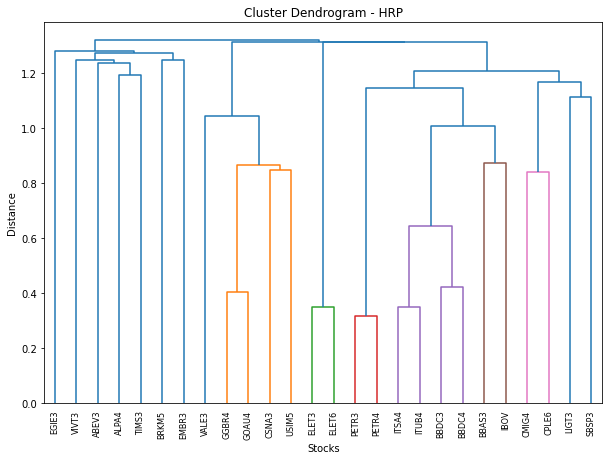

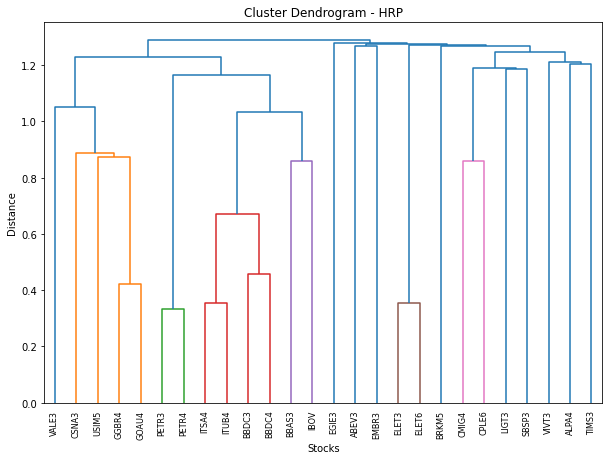

In [65]:
for i in data:
    weights = HRP.HRP_Portfolio(i.iloc[:, 1:], graph=True)

##### Plotting rolling window returns for each strategy

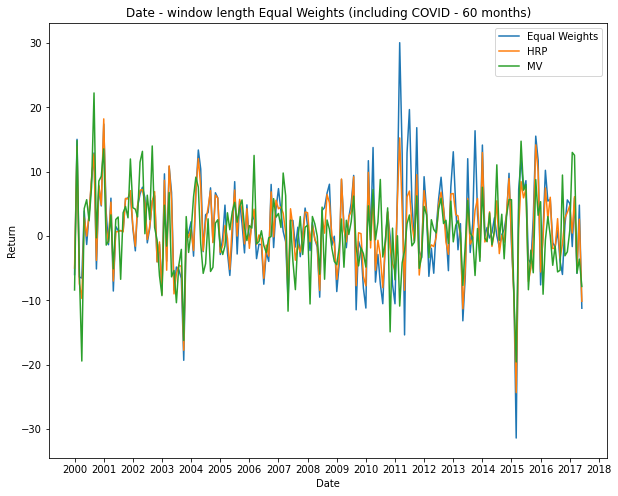

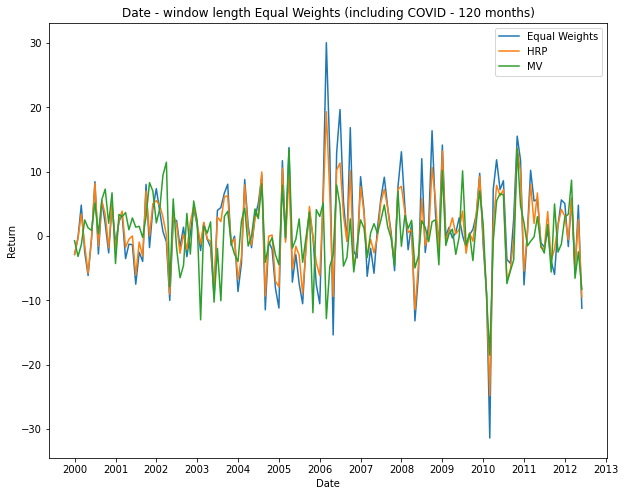

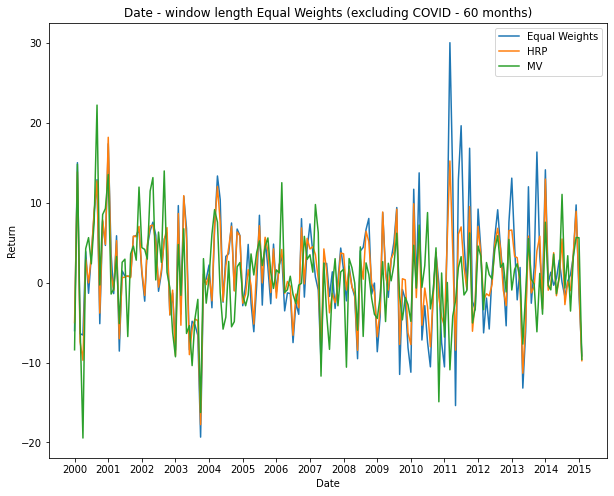

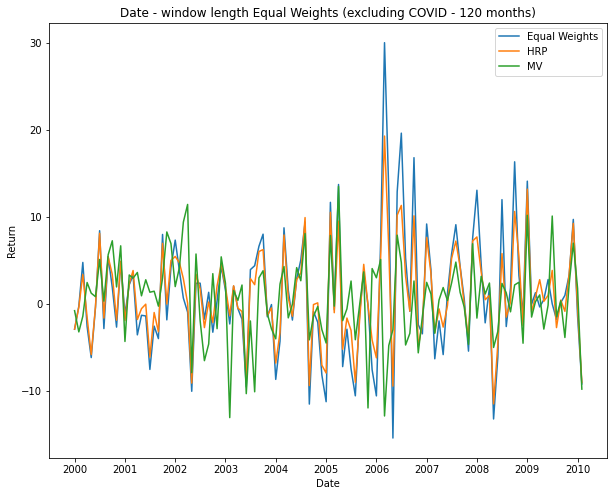

In [66]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the returns for each strategy and save as individual images
for i, j in enumerate(data_hrp):
    fig, ax = plt.subplots(figsize=(10, 8))
    title = f"{j.columns[0]} - window length {j.columns[1]}"
    if i == 0:
        title += " (including COVID - 60 months)"
    elif i == 1:
        title += " (including COVID - 120 months)"
    elif i == 2:
        title += " (excluding COVID - 60 months)"
    else:
        title += " (excluding COVID - 120 months)"
    ax.set_title(title)
    
    # Plot the line chart
    for col_name in j.columns[1:]:
        ax.plot(j['Date'], j[col_name], label=col_name)
        ax.legend()
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.set_xlabel('Date')
    ax.set_ylabel('Return')

    plt.show()

#### Adding descriptive statistics to each strategy

In [67]:
strategies_stats = generate_stats(data_hrp, ["60c", "120c", "60", "120"], 'data/strategies_stats.csv')
strategies_stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
60cEqual Weights,210.0,1.386803,7.229703,-31.408236,-2.551578,0.932156,5.759169,30.035784,-0.104048,2.463730
60cHRP,210.0,1.099114,5.741957,-24.351178,-1.885111,0.662115,5.233654,18.195712,-0.388077,1.713276
60cMV,210.0,0.641974,6.037373,-19.587298,-2.849305,0.832024,3.949736,22.224778,-0.083864,1.383450
120cEqual Weights,150.0,1.115823,7.432773,-31.408236,-2.568566,0.549996,5.057311,30.035784,-0.016364,2.992234
120cHRP,150.0,0.961312,5.723846,-24.843628,-1.974548,0.284161,4.593237,19.309657,-0.358558,2.373657
120cMV,150.0,0.497187,5.120691,-18.515416,-2.623571,1.009021,3.311184,13.579936,-0.424090,1.227344
60Equal Weights,182.0,1.421027,6.923970,-19.326889,-2.505009,0.816569,5.679480,30.035784,0.392898,1.371078
60HRP,182.0,1.157554,5.460855,-17.765295,-1.772886,0.632311,5.152083,18.195712,-0.035909,0.555469
60MV,182.0,0.715305,5.730201,-19.441430,-2.230946,1.018078,3.602431,22.224778,-0.050432,1.721205
120Equal Weights,122.0,1.104687,7.033823,-15.380429,-2.551578,0.108122,4.398289,30.035784,0.718628,1.915409


#### Plotting correlation heatmap to each strategy

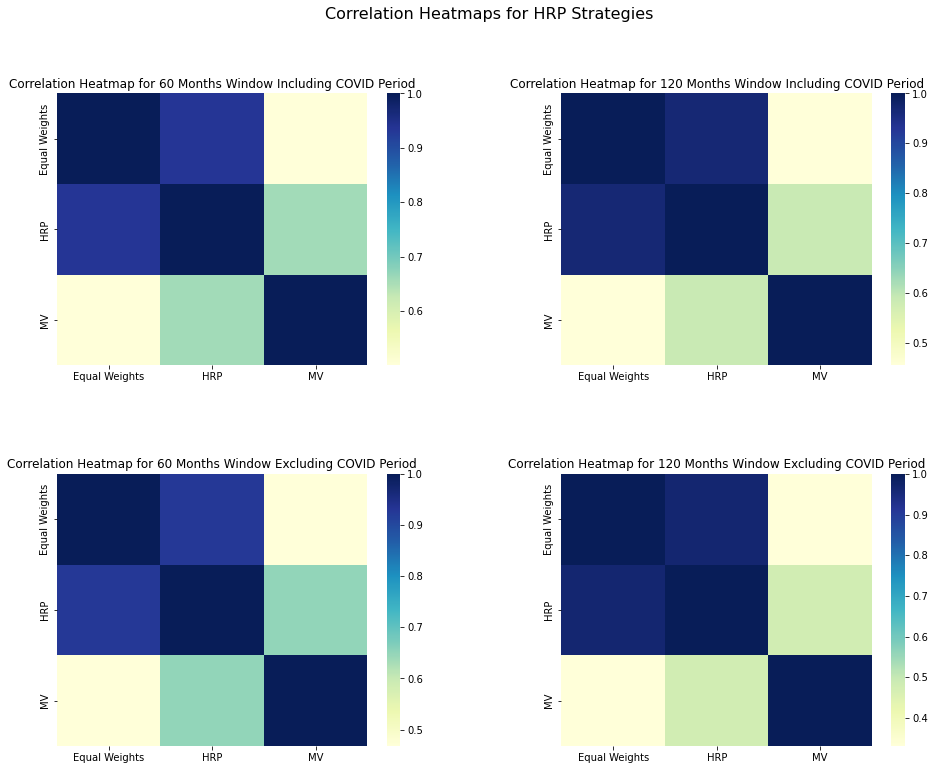

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for i, j in enumerate(data_hrp):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    sns.heatmap(j.corr(), cmap="YlGnBu", ax=ax)
    if i == 0:
        ax.set_title("Correlation Heatmap for 60 Months Window Including COVID Period")
    elif i == 1:
        ax.set_title("Correlation Heatmap for 120 Months Window Including COVID Period")
    elif i == 2:
        ax.set_title("Correlation Heatmap for 60 Months Window Excluding COVID Period")
    else:
        ax.set_title("Correlation Heatmap for 120 Months Window Excluding COVID Period")

fig.suptitle('Correlation Heatmaps for HRP Strategies', fontsize=16)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()


#### Plotting the correlation heatmap to each pair of assets

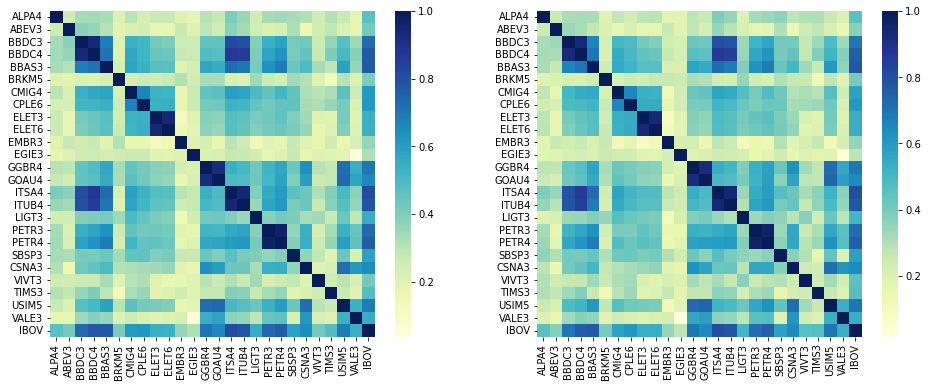

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, j in enumerate(data):
    # if j.equals(data[0]):
    #     axs[i].set_title(f"Correlation Heatmap for Assets (including COVID period)")
    # else:
    #     axs[i].set_title(f"Correlation Heatmap for Assets (excluding COVID period)")
    sns.heatmap(j.corr(), cmap="YlGnBu", ax=axs[i])

plt.show()


In [70]:
for i, j in enumerate(data):
    if j.equals(data[0]):
        file_name = f"data\corr_matrix_including_covid.csv"
    else:
        file_name = f"data\corr_matrix_excluding_covid.csv"
        
    corr_matrix = j.corr()
    corr_matrix.to_csv(file_name)


#### Metrics

In [71]:
# removing date
data_hrp_w_date = []

for i in range(len(data_hrp)):
    df_result = data_hrp[i].iloc[:, 1:] # skipping the 'Data' column
    data_hrp_w_date.append(df_result)

# Define helper functions for calculating metrics
def annualize_return(return_series):
    return (1 + return_series.mean()) ** 12 - 1

def annualize_std(return_series):
    return return_series.std() * np.sqrt(12)

def sharpe_ratio(return_series, risk_free_rate):
    excess_return = return_series - risk_free_rate
    return np.sqrt(12) * excess_return.mean() / excess_return.std()

def adjusted_sharpe_ratio(return_series, risk_free_rate, factor_loadings):
    excess_return = return_series - risk_free_rate
    denominator = np.sqrt(12 * (1 + (factor_loadings ** 2).sum()))
    return (np.sqrt(12) * excess_return.mean() / excess_return.std()) / denominator

def sortino_ratio(return_series, risk_free_rate):
    downside_returns = return_series - risk_free_rate
    downside_std = downside_returns[downside_returns < 0].std() * np.sqrt(12)
    return np.sqrt(12) * (return_series.mean() - risk_free_rate) / downside_std

In [72]:
# Define parameters
risk_free_rate = 0.1375 # annualized SELIC for march 2023
factor_loadings = np.array([0.5, 0.3, 0.2])  # Assuming 3 factors

# Define output DataFrame
results = pd.DataFrame()

# Loop over each dataframe in data_hrp_w_date and calculate metrics
for i in range(len(data_hrp_w_date)):
    if i == 0:
        name = '60m_covid'
    elif i == 1:
        name = '120m_covid'
    elif i == 2:
        name = '60m_wo_covid'
    else:
        name = '120m_wo_covid'
    
    # Calculate metrics for each column (assuming returns are already in decimal form)
    df = data_hrp_w_date[i]
    av = df.mean() * 12
    sd = df.std() * np.sqrt(12)
    sr = sharpe_ratio(df, risk_free_rate)
    asr = adjusted_sharpe_ratio(df, risk_free_rate, factor_loadings)
    sor = sortino_ratio(df, risk_free_rate)
    to = (np.abs(df.diff()).sum() / 2) / df.shape[0]
    ssw = (df ** 2).sum() / df.shape[0]
    
    # Combine results into a single row for this dataframe
    row = pd.DataFrame({
        f'{name}_AV': av,
        f'{name}_SD': sd,
        f'{name}_SR': sr,
        f'{name}_ASR': asr,
        f'{name}_SoR': sor,
        f'{name}_TO': to,
        f'{name}_SSW': ssw
    })
    
    # Append row to results dataframe
    results = pd.concat([results, row], axis=1)


In [73]:
results = results.rename_axis('metric').reset_index()
results_transposed = results.T
results_transposed.columns = results_transposed.iloc[0]
results_transposed = results_transposed.iloc[1:]
results_transposed.to_csv("data/metrics.csv")
